# Тема “Тюнинг гиперпараметров, построение ансамблей алгоритмов.”


<hr>
<b>Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:
    
    Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.
<hr>
Задания:
<ol>
<li><a href="#task_1">Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
</a>
<li><a href = "#task_2">Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
</a>
<li><a href = "#task_3">Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
</a>
<li><a href = "#task_4">Выполнить задание 2 для трех моделей.
</a>
<li><a href = "#task_5">(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.
</a>
<li><a href = "#task_6">(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.
</a>
</ol>

## Импорт библиотек

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import seaborn as sns
import matplotlib.pyplot as plt



from catboost import Pool
from catboost.utils import get_roc_curve


from sklearn.metrics import (f1_score, roc_auc_score,
                             precision_score, classification_report,
                             precision_recall_curve, confusion_matrix)
from sklearn.model_selection import  KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin


warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
def optimization_memory_usage(df: pd.DataFrame, category=True):
    """ 
    Функция оптимизации числовых значений по int[8, 16, 32, 64] по float[16, 32, 64]
    с преобразованием object -> category
    """
    start_memory_usage = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_memory_usage:.2f} MB')
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type != object: 
            col_min = df[column].min()
            col_max = df[column].max()
            if str(column_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)

                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)

                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)

                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64) 
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)

                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)

                else:
                    df[column] = df[column].astype(np.float64)
        elif category:
            df[column] = df[column].astype('category')
        else:
            continue
            
    end_memory_usage = df.memory_usage().sum() / 1024**2
    percent_optimization  = 100 * (start_memory_usage - end_memory_usage) / start_memory_usage
    print(f'Memory usage after optimization is: {end_memory_usage:.2f} MB')
    print(f'Decreased by {percent_optimization:.1f}%')
    
    return df


def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])
    
    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder
            
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc",
            verbose=0,
            early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("==="*33)
    return estimators, encoders, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])
    
    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=0,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("==="*33)
    return estimators, encoders, oof_preds

def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T


def get_duplicated(data, key):
    return data.duplicated(subset=[key]).value_counts()

## Загрузка данных

In [3]:
train_df = pd.read_csv('../course_project/data/train.csv')
test_df = pd.read_csv('../course_project/data/test.csv')
bki_df = pd.read_csv('../course_project/data/bki.csv')
client_profile_df = pd.read_csv('../course_project/data/client_profile.csv')
payments_df = pd.read_csv('../course_project/data/payments.csv')
applications_history_df = pd.read_csv('../course_project/data/applications_history.csv')

df_dict = {'train.csv': train_df, 'test.csv': test_df,
           'bki.csv': bki_df, 'client_profile.csv': client_profile_df,
           'payments.csv': payments_df, 'applications_history.csv':applications_history_df}

In [4]:
for key, value in df_dict.items():
    df_dict[key] = optimization_memory_usage(value, category=False)

Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 1.37 MB
Decreased by 45.8%
Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 1.89 MB
Decreased by 25.0%
Memory usage of dataframe is 122.60 MB
Memory usage after optimization is: 60.40 MB
Decreased by 50.7%
Memory usage of dataframe is 45.78 MB
Memory usage after optimization is: 17.40 MB
Decreased by 62.0%
Memory usage of dataframe is 62.50 MB
Memory usage after optimization is: 23.44 MB
Decreased by 62.5%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 219.81 MB
Decreased by 33.7%


In [5]:
for key, value in df_dict.items():
    print(f"{key}\n{get_duplicated(value, key='APPLICATION_NUMBER')}\n{'---'*13}")

train.csv
False    110093
dtype: int64
---------------------------------------
test.csv
False    165141
dtype: int64
---------------------------------------
bki.csv
True     672103
False    273131
dtype: int64
---------------------------------------
client_profile.csv
False    250000
dtype: int64
---------------------------------------
payments.csv
True     759206
False    264726
dtype: int64
---------------------------------------
applications_history.csv
True     1331357
False     338857
dtype: int64
---------------------------------------


Дубликаты отсутствуют в датасетах train.csv, test.csv, client_profile.csv.

Можно объединить:
    
    train.csv & client_profile.csv,
    test.csv & client_profile.csv

In [6]:
train_df.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash


In [7]:
train_data = pd.merge(train_df, client_profile_df, on='APPLICATION_NUMBER', how='left')
test_data = pd.merge(test_df, client_profile_df, on='APPLICATION_NUMBER', how='left')

In [8]:
target, train_data = train_data['TARGET'], train_data.drop(['TARGET'], axis=1)


In [9]:
train_data.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019104,...,3.0,0.700684,0.645996,0.716797,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026398,...,2.0,NaN,0.682129,0.267822,0.0,0.0,0.0,7.0,0.0,4.0


## Выполнение заданий

Параметры моделей

In [10]:
lgb_params = { 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': True,
    'random_state': 21,
    'silent': -1,
    'verbose': -1,
}



xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 21
}

cb_params = {
    "n_estimators": 2000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 21
}

<p><a name="task_1"></a></p>

### Задание 1: Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.


In [11]:
train_cat_features = train_data.select_dtypes(include=[np.object]).columns.to_list()
train_cat_features

['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS']

In [12]:
lgb_cv = KFold(n_splits=10, random_state=21, shuffle=True)


In [13]:
lgb_estimators, _, lgb_oof_preds = lightgbm_cross_validation(lgb_params,
                                                             train_data,
                                                             target,
                                                             lgb_cv,
                                                             train_cat_features
                                                            )

Fri Oct 29 16:39:16 2021, Cross-Validation, 110093 rows, 25 cols
Fold 1, Valid score = 0.70453
Fold 2, Valid score = 0.72548
Fold 3, Valid score = 0.72524
Fold 4, Valid score = 0.71858
Fold 5, Valid score = 0.7016
Fold 6, Valid score = 0.7282
Fold 7, Valid score = 0.71808
Fold 8, Valid score = 0.72422
Fold 9, Valid score = 0.72647
Fold 10, Valid score = 0.72974
Score by each fold: [0.70453, 0.72548, 0.72524, 0.71858, 0.7016, 0.7282, 0.71808, 0.72422, 0.72647, 0.72974]


In [14]:
score = roc_auc_score(target, lgb_oof_preds)
print(f"Score = {round(score, 5)}")

Score = 0.71932


In [15]:
xgb_cv = KFold(n_splits=10, random_state=21, shuffle=True)


In [16]:
xgb_estimators, _, xgb_oof_preds = xgboost_cross_validation(xgb_params,
                                                            train_data,
                                                            target,
                                                            xgb_cv,
                                                            train_cat_features
                                                           )


Fri Oct 29 16:40:34 2021, Cross-Validation, 110093 rows, 25 cols
Fold 1, Valid score = 0.70671
Fold 2, Valid score = 0.72587
Fold 3, Valid score = 0.72252
Fold 4, Valid score = 0.71702
Fold 5, Valid score = 0.70015
Fold 6, Valid score = 0.7226
Fold 7, Valid score = 0.7155
Fold 8, Valid score = 0.71841
Fold 9, Valid score = 0.72738
Fold 10, Valid score = 0.72484
Score by each fold: [0.70671, 0.72587, 0.72252, 0.71702, 0.70015, 0.7226, 0.7155, 0.71841, 0.72738, 0.72484]


In [17]:
score = roc_auc_score(target, xgb_oof_preds)
print(f"Score = {round(score, 5)}")

Score = 0.71762


In [18]:
scores = pd.DataFrame({
    "lgb_oof_preds": lgb_oof_preds,
    "xgb_oof_preds": xgb_oof_preds,
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

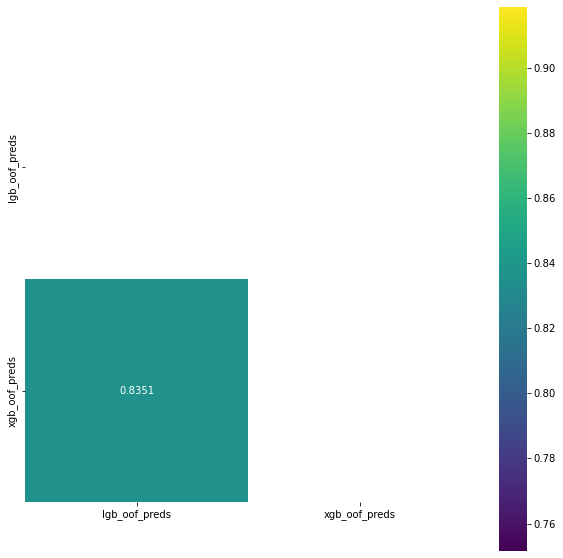

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

<p><a name="task_2"></a></p>

### Задание 2: Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.


<p><a name="task_3"></a></p>

### Задание 3: Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

<p><a name="task_4"></a></p>

### Задание 4: Выполнить задание 2 для трех моделей.

<p><a name="task_5"></a></p>

### Задание 5: (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.


<p><a name="task_6"></a></p>

### Задание 6 : (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.
